In [76]:
import pickle

In [112]:
from sklearn import preprocessing
from emnist import extract_training_samples
import numpy as np

images, labels = extract_training_samples('letters')

images = np.array([preprocessing.normalize(image_i, norm='max') for image_i in images])

num_of_pictures, height, width = images.shape
num_classes = np.unique(labels).shape[0] + 1

print(
    f'Количество картинок: {num_of_pictures}. \nРазмер каждой картинки: {height}x{width}\nЧисло классов: {num_classes}')

Количество картинок: 124800. 
Размер каждой картинки: 28x28
Число классов: 27


In [120]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=42)

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

X_train = X_train.reshape(-1, height, width, 1)
X_test = X_test.reshape(-1, height, width, 1)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_train: {X_test.shape}, y_train: {y_test.shape}')


X_train: (83616, 28, 28, 1), y_train: (83616, 27)
X_train: (41184, 28, 28, 1), y_train: (41184, 27)


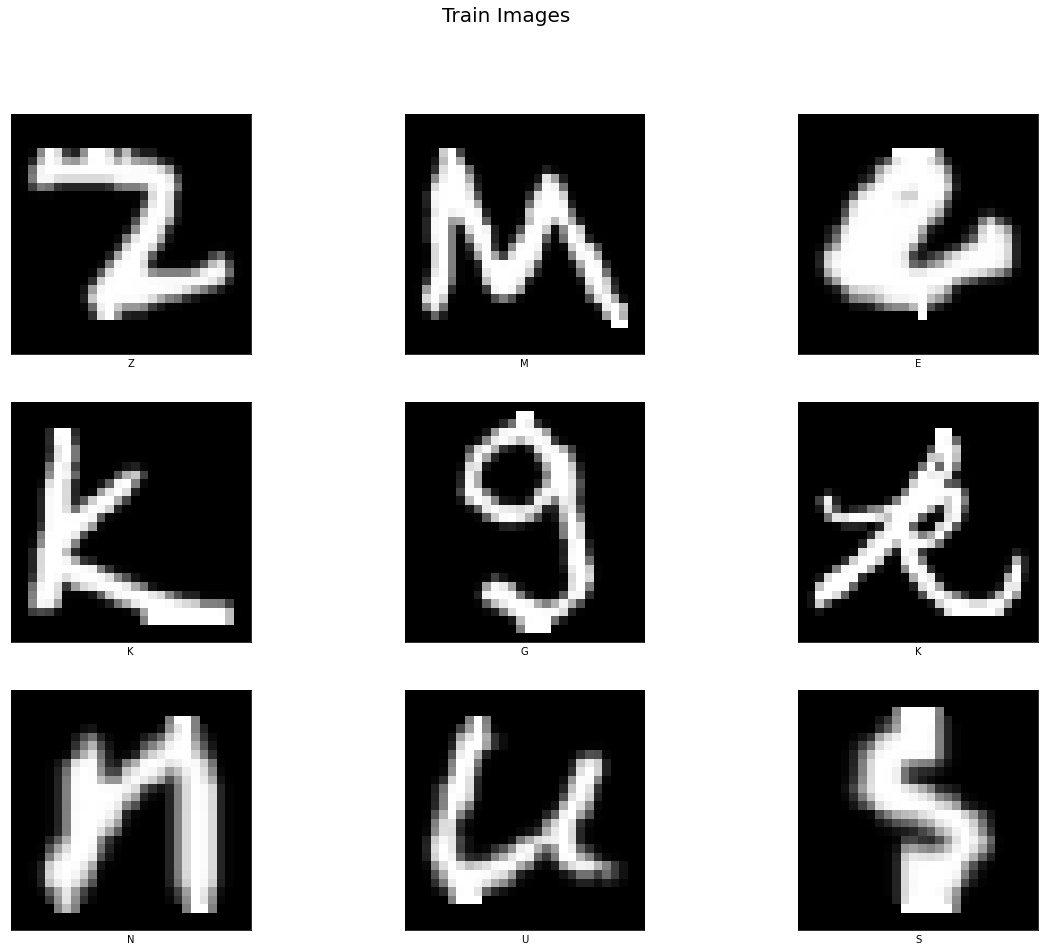

In [114]:
import string
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
plt.suptitle("Train Images", fontsize=20)

alphabet_string = string.ascii_uppercase
iter = 0

while iter < 9:
    image_num = random.randint(0, X_train.shape[0])

    plt.subplot(3, 3, iter + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(alphabet_string[labels[image_num] - 1])
    plt.imshow(images[image_num], cmap=plt.get_cmap('gray'))

    iter += 1


In [201]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
import tensorflow as tf

def create_model_1():
    model = Sequential()

    model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu',
                     input_shape=(height, width, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(.5))

    # Задача многоклассовой классификации
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


def create_model_2():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(height, width, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))

    # Задача многоклассовой классификации
    model.add(Dense(units=num_classes, activation='softmax'))

    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


    return model

In [207]:
from keras.callbacks import CSVLogger
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, random_state=42, shuffle=True)

models_list = []
scores, histories = [], []

# csv_logger = CSVLogger('log.csv', append=True, separator=';')
for train_index, test_index in cv.split(X_train):
    model = create_model_2()
    trainX, trainY, testX, testY = X_train[train_index], y_train[train_index], X_train[test_index], y_train[test_index]
    print(train_index.shape)
    print(test_index.shape)

    history = model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=1,
                        validation_data=(testX, testY))

    _, acc = model.evaluate(X_test, y_test, verbose=0)
    models_list.append(model)
    scores.append(acc)
    histories.append(history)

# with open('nn_models_5kfolds_Adam.pickle', 'wb') as f:
#     pickle.dump([models_list, scores, histories], f)

(66892,)
(16724,)
Epoch 1/10
2091/2091 [==============================] - 11s 5ms/step - loss: 0.6414 - accuracy: 0.8040 - val_loss: 0.4124 - val_accuracy: 0.8699
Epoch 2/10
2091/2091 [==============================] - 11s 5ms/step - loss: 0.3170 - accuracy: 0.8965 - val_loss: 0.3388 - val_accuracy: 0.8921
Epoch 3/10
2091/2091 [==============================] - 11s 5ms/step - loss: 0.2448 - accuracy: 0.9176 - val_loss: 0.3109 - val_accuracy: 0.9038
Epoch 4/10
2091/2091 [==============================] - 11s 5ms/step - loss: 0.2007 - accuracy: 0.9307 - val_loss: 0.3050 - val_accuracy: 0.9079
Epoch 5/10
2091/2091 [==============================] - 11s 5ms/step - loss: 0.1647 - accuracy: 0.9418 - val_loss: 0.3174 - val_accuracy: 0.9034
Epoch 6/10
2091/2091 [==============================] - 11s 5ms/step - loss: 0.1396 - accuracy: 0.9493 - val_loss: 0.3239 - val_accuracy: 0.9068
Epoch 7/10
2091/2091 [==============================] - 11s 5ms/step - loss: 0.1162 - accuracy: 0.9573 - val_los

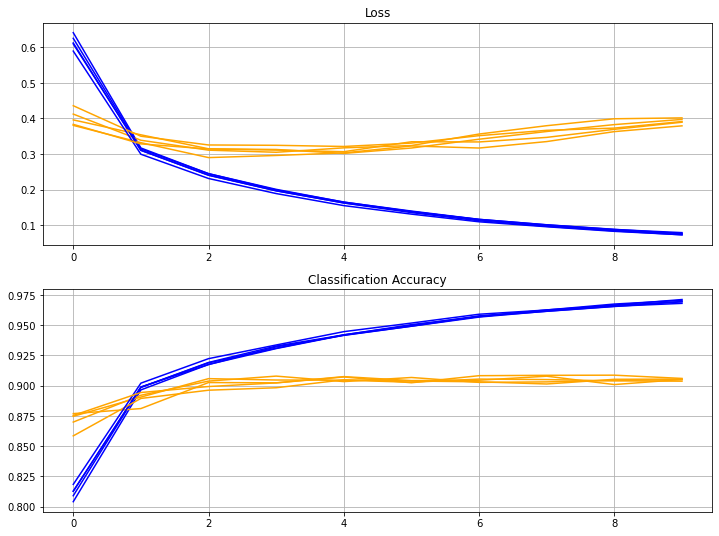

In [208]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(12, 9)
)

plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

for i in range(len(histories)):
    # plot loss
    plt.grid(True)
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    # plot accuracy

    plt.grid(True)
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')

plt.savefig("nn.png")
plt.show()


In [210]:
# print summary
print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
# box and whisker plots of results
# plt.boxplot(scores)
# plt.show()

Accuracy: mean=90.498 std=0.165, n=5
